<a href="https://colab.research.google.com/github/rakshithashri/Predicting-House-Prices/blob/main/Predicting_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [23]:
### STEP1: settings
from enum import Enum

class Settings(Enum):
    train_path = '/content/drive/MyDrive/train.csv'
    test_path = '/content/drive/MyDrive/test.csv'

    def __str__(self):
        return self.value

In [24]:

### STEP2: data processing
def display_outlier(pd, feature):
    fig, ax = plt.subplots()
    ax.scatter(x = pd[feature], y = pd['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show()

def display_distrib(pd, feature):
    plt.figure()
    sns.distplot(pd[feature].dropna() , fit=norm);
    (mu, sigma) = norm.fit(pd[feature].dropna())

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('SalePrice distribution')
    plt.show()

def process_data(train_path, test_path):
    print('[data_processing] ', train_path)
    print('[data_processing] ', test_path)

    global train
    global test
    global y_train
    global train_ID
    global test_ID

    # load data
    train = pd.read_csv(str(train_path))
    test = pd.read_csv(str(test_path))

    #print('[data_processing] ', train.head(5))
    #print('[data_processing] ', test.head(5))

    # drop ID feature
    print('[data_processing] ', 'The train data size before dropping Id: {} '.format(train.shape))
    print('[data_processing] ', 'The test data size before dropping Id: {} '.format(test.shape))

    train_ID = train['Id']
    test_ID = test['Id']

    train.drop('Id', axis = 1, inplace = True)
    test.drop('Id', axis = 1, inplace = True)

    print('[data_processing] ', 'The train data size after dropping Id: {} '.format(train.shape))
    print('[data_processing] ', 'The test data size after dropping Id: {} '.format(test.shape))

    # analyze and remove huge outliers: GrLivArea, ...
    display_outlier(train, 'GrLivArea')
    train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
    display_outlier(train, 'GrLivArea')

    # normalize distribution of output (SalePrice)
    display_distrib(train, 'SalePrice')
    train["SalePrice"] = np.log1p(train["SalePrice"])
    y_train = train.SalePrice.values
    display_distrib(train, 'SalePrice')

    # concatenate the train and test data
    ntrain = train.shape[0]
    ntest = test.shape[0]
    train.drop(['SalePrice'], axis=1, inplace=True)
    all_data = pd.concat((train, test)).reset_index(drop=True)
    print('[data_processing] ', 'all_data size is : {}'.format(all_data.shape))

    # fill missing data
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print('[data_processing] ', missing_data)

    all_data["PoolQC"] = all_data["PoolQC"].fillna("None") #data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None") #data description says NA means "no misc feature"
    all_data["Alley"] = all_data["Alley"].fillna("None") #data description says NA means "no alley access"
    all_data["Fence"] = all_data["Fence"].fillna("None") #NA means "no fence"
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None") #NA means "no fireplace"
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))  # fill by the median LotFrontage of all neighborhood because they have same lot frontage
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None') #NaN means that there is no basement
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None") #NA means no masonry veneer
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) #NA means no masonry veneer
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'], axis=1) #For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it
    all_data["Functional"] = all_data["Functional"].fillna("Typ") #data description says NA means typical
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0]) #It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0]) #Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0]) #Fill in again with most frequent which is "WD"
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None") #Na most likely means No building class. We can replace missing values with None

    # add important features more
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] #feature which is the total area of basement, first and second floor areas of each house

    # normalize skewed features
    for feature in all_data:
        if all_data[feature].dtype != "object":
                #display_distrib(all_data, feature)
                all_data[feature] = np.log1p(all_data[feature])
                #display_distrib(all_data, feature)

    # transform numeric features into categorical features
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['OverallQual'] = all_data['OverallQual'].astype(str)
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)

    # encode categorical features by LabelEncoder or dummies
    # do label encoding for categorical features
    categorical_features = \
    ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
     'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
     'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
     'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual',
     'OverallCond', 'YrSold', 'MoSold')
    for c in categorical_features:
        lbl = LabelEncoder()
        lbl.fit(list(all_data[c].values))
        all_data[c] = lbl.transform(list(all_data[c].values))
    print('[data_processing] ', 'Shape all_data: {}'.format(all_data.shape))
    # get dummy categorical features
    all_data = pd.get_dummies(all_data)
    print('[data_processing] ', all_data.shape)

    train = all_data[:ntrain]
    test = all_data[ntrain:]

[data_processing]  /content/drive/MyDrive/train.csv
[data_processing]  /content/drive/MyDrive/test.csv
[data_processing]  The train data size before dropping Id: (1460, 81) 
[data_processing]  The test data size before dropping Id: (1459, 80) 
[data_processing]  The train data size after dropping Id: (1460, 80) 
[data_processing]  The test data size after dropping Id: (1459, 79) 


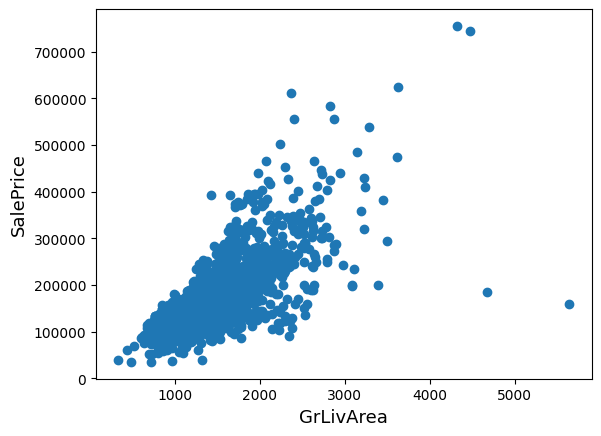

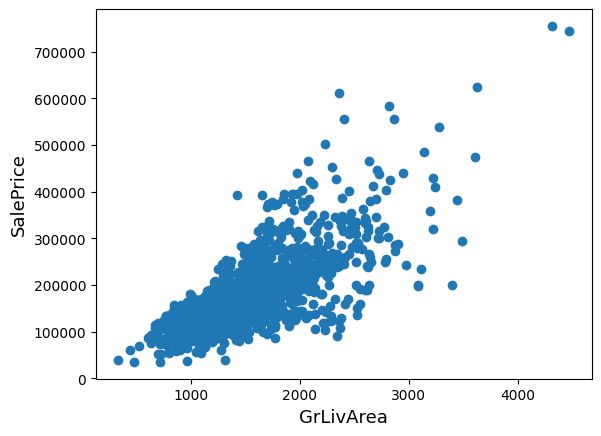

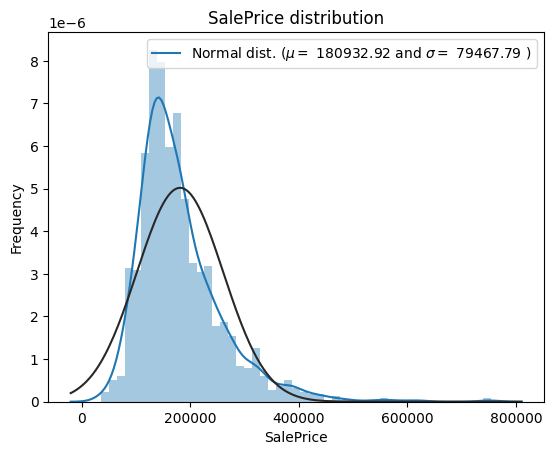

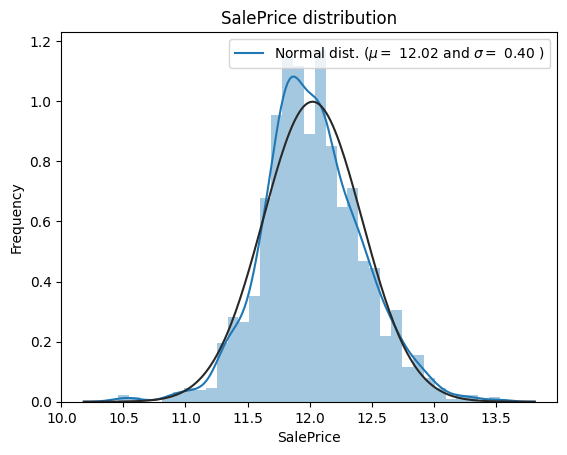

[data_processing]  all_data size is : (2917, 79)
[data_processing]                Missing Ratio
PoolQC            99.691464
MiscFeature       96.400411
Alley             93.212204
Fence             80.425094
FireplaceQu       48.680151
LotFrontage       16.660953
GarageFinish       5.450806
GarageQual         5.450806
GarageCond         5.450806
GarageYrBlt        5.450806
GarageType         5.382242
BsmtExposure       2.811107
BsmtCond           2.811107
BsmtQual           2.776826
BsmtFinType2       2.742544
BsmtFinType1       2.708262
MasVnrType         0.822763
MasVnrArea         0.788481
MSZoning           0.137127
BsmtFullBath       0.068564
BsmtHalfBath       0.068564
Functional         0.068564
Utilities          0.068564
GarageArea         0.034282
GarageCars         0.034282
Electrical         0.034282
KitchenQual        0.034282
TotalBsmtSF        0.034282
BsmtUnfSF          0.034282
BsmtFinSF2         0.034282
[data_processing]  Shape all_data: (2917, 79)
[data_processing] 

In [34]:
### STEP3: model
class Averaging_Models(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

class Stacking_Averaged_Models(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # we again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=15)

        # train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # do the predictions of all base models on the test data and use the averaged predictions as
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def model():
    # LASSO Regression
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

    score = rmsle_cv(lasso)
    print('[model] ', "Lasso score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # Elastic Net Regression
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

    score = rmsle_cv(ENet)
    print('[model] ', "ElasticNet score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # Kernel Ridge Regression
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

    score = rmsle_cv(KRR)
    print('[model] ', "Kernel Ridge score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # Gradient Boosting Regression
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)

    score = rmsle_cv(GBoost)
    print('[model] ', "Gradient Boosting score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # XGBoost
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1)

    score = rmsle_cv(model_xgb)
    print('[model] ', "Xgboost score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # LightGBM
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

    score = rmsle_cv(model_lgb)
    print('[model] ', "LGBM score(cv): {:.4f} ({:.4f})" .format(score.mean(), score.std()))

    # averaged model
    averaged_models = Averaging_Models(models = (ENet, GBoost, KRR, lasso))

    score = rmsle_cv(averaged_models)
    print('[model] ', "Averaged base models score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # stacked averaged model
    stacked_averaged_models = Stacking_Averaged_Models(base_models = (ENet, GBoost, KRR), meta_model = lasso)

    score = rmsle_cv(stacked_averaged_models)
    print('[model] ', "Stacked averaged-models score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))

    # StackedRegressor
    stacked_averaged_models.fit(train.values, y_train)
    stacked_train_pred = stacked_averaged_models.predict(train.values)
    stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
    print('[model] ', 'stacked regressor:', rmsle(y_train, stacked_train_pred))

    # XGBoost
    model_xgb.fit(train, y_train)
    xgb_train_pred = model_xgb.predict(train)
    xgb_pred = np.expm1(model_xgb.predict(test))
    print('[model] ', 'xgboost:', rmsle(y_train, xgb_train_pred))

    # LightGBM
    model_lgb.fit(train, y_train)
    lgb_train_pred = model_lgb.predict(train)
    lgb_pred = np.expm1(model_lgb.predict(test.values))
    print('[model] ', 'LightGBMs:', rmsle(y_train, lgb_train_pred))

    print('[model] ', 'ensemble:', rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

    ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

    sub = pd.DataFrame()
    sub['Id'] = test_ID
    sub['SalePrice'] = ensemble
    sub.to_csv('submission.csv',index=False)


### MAIN
process_data(Settings.train_path, Settings.test_path)
model()

print('The end!')
